In [18]:
# Conexao com o banco de dados
import psycopg2
import pandas as pd

DB_CONFIG = {
    'host': 'localhost',
    'port': '5432',
    'database': 'assistencia_saude',
    'user': 'postgres',
    'password': '2301'
}

def conectar():
    return psycopg2.connect(**DB_CONFIG)

print('Conexao configurada!')

Conexao configurada!


## 🗃️ Povoar Banco de Dados (Executar uma vez para criar dados de teste)

In [26]:
# ====================================
# POVOAR BANCO DE DADOS - DADOS DE TESTE
# Execute apenas UMA VEZ para criar os dados
# ====================================

def povoar_banco():
    """Insere dados de exemplo em todas as tabelas"""
    conn = psycopg2.connect(**DB_CONFIG)
    conn.autocommit = True
    cur = conn.cursor()
    
    try:
        # Verificar se ja tem dados em Pessoa
        cur.execute("SELECT COUNT(*) FROM Pessoa")
        if cur.fetchone()[0] > 0:
            print("⚠️ Banco já possui dados! Pulando inserção...")
            return
        
        # Buscar IDs das agencias existentes
        cur.execute("SELECT id FROM Agencia ORDER BY id LIMIT 3")
        agencias = [row[0] for row in cur.fetchall()]
        
        if len(agencias) < 3:
            print("❌ Precisa de pelo menos 3 agências no banco!")
            return
        
        ag1, ag2, ag3 = agencias[0], agencias[1], agencias[2]
        print(f"📍 Usando Agências com IDs: {ag1}, {ag2}, {ag3}")
        
        # PROFISSIONAIS
        cur.execute(f"""
            INSERT INTO Profissional (agencia_id, nome, cpf, telefone, email, especialidade) VALUES 
            ({ag1}, 'Dr. Carlos Silva', '111.111.111-11', '11-99999-1111', 'carlos@email.com', 'Clinico Geral'),
            ({ag1}, 'Dra. Ana Santos', '222.222.222-22', '11-99999-2222', 'ana@email.com', 'Pediatra'),
            ({ag2}, 'Dr. Pedro Oliveira', '333.333.333-33', '11-99999-3333', 'pedro@email.com', 'Cardiologista'),
            ({ag3}, 'Dra. Maria Costa', '444.444.444-44', '11-99999-4444', 'maria@email.com', 'Ginecologista')
        """)
        print("✅ Profissionais inseridos")
        
        # Buscar IDs dos profissionais
        cur.execute("SELECT id FROM Profissional ORDER BY id")
        profs = [row[0] for row in cur.fetchall()]
        p1, p2, p3, p4 = profs[-4], profs[-3], profs[-2], profs[-1]
        print(f"📍 Usando Profissionais com IDs: {p1}, {p2}, {p3}, {p4}")
        
        # FAMILIAS
        cur.execute("""
            INSERT INTO Familia (codigo_familiar, responsavel, situacao_vulnerabilidade) VALUES 
            ('FAM001', 'Joao da Silva', 'Baixa renda'),
            ('FAM002', 'Maria Oliveira', 'Extrema pobreza'),
            ('FAM003', 'Carlos Santos', 'Baixa renda')
        """)
        print("✅ Famílias inseridas")
        
        # Buscar IDs das familias
        cur.execute("SELECT id FROM Familia ORDER BY id")
        fams = [row[0] for row in cur.fetchall()]
        f1, f2, f3 = fams[-3], fams[-2], fams[-1]
        
        # ENDERECOS
        cur.execute(f"""
            INSERT INTO Endereco (familia_id, logradouro, numero, bairro, cidade, estado, cep) VALUES 
            ({f1}, 'Rua das Flores', '123', 'Centro', 'Sao Paulo', 'SP', '01000-000'),
            ({f2}, 'Av. Brasil', '456', 'Jardim', 'Sao Paulo', 'SP', '02000-000'),
            ({f3}, 'Rua Nova', '789', 'Vila Nova', 'Sao Paulo', 'SP', '03000-000')
        """)
        print("✅ Endereços inseridos")
        
        # PESSOAS
        cur.execute(f"""
            INSERT INTO Pessoa (familia_id, nome, cpf, data_nascimento, sexo, gestante, deficiencia, telefone) VALUES 
            ({f1}, 'Joao da Silva', '123.456.789-01', '1980-05-15', 'M', FALSE, NULL, '11-98888-1111'),
            ({f1}, 'Ana Silva', '123.456.789-02', '1985-03-20', 'F', TRUE, NULL, '11-98888-1112'),
            ({f2}, 'Maria Oliveira', '234.567.890-01', '1975-08-10', 'F', FALSE, NULL, '11-98888-2222'),
            ({f2}, 'Pedro Oliveira', '234.567.890-02', '2010-12-01', 'M', FALSE, NULL, '11-98888-2223'),
            ({f3}, 'Carlos Santos', '345.678.901-01', '1990-01-25', 'M', FALSE, 'Visual', '11-98888-3333'),
            ({f3}, 'Julia Santos', '345.678.901-02', '1992-07-30', 'F', TRUE, NULL, '11-98888-3334')
        """)
        print("✅ Pessoas inseridas")
        
        # Buscar IDs das pessoas
        cur.execute("SELECT id FROM Pessoa ORDER BY id")
        pessoas = [row[0] for row in cur.fetchall()]
        pe1, pe2, pe3, pe4, pe5, pe6 = pessoas[-6], pessoas[-5], pessoas[-4], pessoas[-3], pessoas[-2], pessoas[-1]
        print(f"📍 Usando Pessoas com IDs: {pe1}, {pe2}, {pe3}, {pe4}, {pe5}, {pe6}")
        
        # UNIDADES DE SAUDE
        cur.execute("""
            INSERT INTO UnidadeSaude (nome, tipo, endereco) VALUES 
            ('UBS Centro', 'UBS', 'Rua Principal, 100'),
            ('UBS Norte', 'UBS', 'Av. Norte, 500'),
            ('Hospital Municipal', 'Hospital', 'Rua Hospital, 1000'),
            ('Clinica Popular', 'Clinica', 'Rua Comercio, 200')
        """)
        print("✅ Unidades de Saúde inseridas")
        
        # Buscar IDs das unidades
        cur.execute("SELECT id FROM UnidadeSaude ORDER BY id")
        unidades = [row[0] for row in cur.fetchall()]
        u1, u2, u3 = unidades[-4], unidades[-3], unidades[-2]
        
        # MEDICAMENTOS
        cur.execute("""
            INSERT INTO Medicamento (nome, principio_ativo) VALUES 
            ('Paracetamol 500mg', 'Paracetamol'),
            ('Amoxicilina 500mg', 'Amoxicilina'),
            ('Omeprazol 20mg', 'Omeprazol'),
            ('Losartana 50mg', 'Losartana'),
            ('Metformina 850mg', 'Metformina')
        """)
        print("✅ Medicamentos inseridos")
        
        # Buscar IDs dos medicamentos
        cur.execute("SELECT id FROM Medicamento ORDER BY id")
        meds = [row[0] for row in cur.fetchall()]
        m1, m2, m3, m4 = meds[-5], meds[-4], meds[-3], meds[-2]
        
        # CONSULTAS
        cur.execute(f"""
            INSERT INTO Consulta (pessoa_id, profissional_id, data_consulta, hora_consulta, tipo_consulta) VALUES 
            ({pe1}, {p1}, '2025-01-10', '08:00', 'Rotina'),
            ({pe2}, {p4}, '2025-01-11', '09:30', 'Pre-natal'),
            ({pe3}, {p1}, '2025-01-12', '10:00', 'Retorno'),
            ({pe4}, {p2}, '2025-01-13', '14:00', 'Pediatrica'),
            ({pe5}, {p3}, '2025-01-14', '15:30', 'Cardiologia'),
            ({pe6}, {p4}, '2025-01-15', '16:00', 'Pre-natal'),
            ({pe1}, {p3}, '2025-02-01', '08:30', 'Cardiologia'),
            ({pe2}, {p4}, '2025-02-10', '10:00', 'Pre-natal')
        """)
        print("✅ Consultas inseridas")
        
        # ATENDIMENTOS
        cur.execute(f"""
            INSERT INTO Atendimento (pessoa_id, profissional_id, unidade_saude_id, data_atendimento, tipo_atendimento, descricao) VALUES 
            ({pe1}, {p1}, {u1}, '2025-01-10', 'Consulta', 'Paciente com dor de cabeca'),
            ({pe2}, {p4}, {u1}, '2025-01-11', 'Pre-natal', 'Acompanhamento gestacional'),
            ({pe3}, {p1}, {u2}, '2025-01-12', 'Retorno', 'Retorno para ver exames'),
            ({pe4}, {p2}, {u2}, '2025-01-13', 'Emergencia', 'Febre alta'),
            ({pe5}, {p3}, {u3}, '2025-01-14', 'Consulta', 'Avaliacao cardiologica')
        """)
        print("✅ Atendimentos inseridos")
        
        # Buscar IDs dos atendimentos
        cur.execute("SELECT id FROM Atendimento ORDER BY id")
        atends = [row[0] for row in cur.fetchall()]
        a1, a2, a4, a5 = atends[-5], atends[-4], atends[-2], atends[-1]
        
        # PRESCRICOES
        cur.execute(f"""
            INSERT INTO Prescricao (pessoa_id, profissional_id, medicamento_id, data_prescricao, dosagem, frequencia, instrucoes) VALUES 
            ({pe1}, {p1}, {m1}, '2025-01-10', '500mg', '8 em 8 horas', 'Tomar por 5 dias'),
            ({pe4}, {p2}, {m1}, '2025-01-13', '250mg', '6 em 6 horas', 'Tomar por 3 dias'),
            ({pe5}, {p3}, {m4}, '2025-01-14', '50mg', '1 vez ao dia', 'Uso continuo'),
            ({pe3}, {p1}, {m3}, '2025-01-12', '20mg', '1 vez ao dia', 'Tomar em jejum'),
            ({pe6}, {p4}, {m2}, '2025-01-15', '500mg', '12 em 12 horas', 'Tomar por 7 dias')
        """)
        print("✅ Prescrições inseridas")
        
        # DIAGNOSTICOS
        cur.execute(f"""
            INSERT INTO Diagnostico (pessoa_id, descricao, data_diagnostico) VALUES 
            ({pe1}, 'Cefaleia tensional', '2025-01-10'),
            ({pe4}, 'Infeccao viral', '2025-01-13'),
            ({pe5}, 'Hipertensao arterial', '2025-01-14'),
            ({pe3}, 'Gastrite', '2025-01-12')
        """)
        print("✅ Diagnósticos inseridos")
        
        # PRONTUARIOS
        cur.execute(f"""
            INSERT INTO Prontuario (pessoa_id, profissional_id, data_registro, historico, observacoes) VALUES 
            ({pe1}, {p1}, '2025-01-10', 'Primeira consulta - queixa de dor de cabeca frequente', 'Solicitar exames'),
            ({pe5}, {p3}, '2025-01-14', 'Paciente com historico familiar de hipertensao', 'Iniciar tratamento'),
            ({pe3}, {p1}, '2025-01-12', 'Paciente com desconforto estomacal', 'Dieta leve')
        """)
        print("✅ Prontuários inseridos")
        
        # PROCEDIMENTOS
        cur.execute(f"""
            INSERT INTO Procedimento (atendimento_id, descricao) VALUES 
            ({a1}, 'Aferir pressao arterial'),
            ({a2}, 'Exame de ultrassom'),
            ({a4}, 'Administrar antitermico'),
            ({a5}, 'Eletrocardiograma')
        """)
        print("✅ Procedimentos inseridos")
        
        print("\n🎉 BANCO POVOADO COM SUCESSO!")
        print("=" * 50)
        print("Dados inseridos:")
        print("- 4 Profissionais") 
        print("- 3 Famílias")
        print("- 3 Endereços")
        print("- 6 Pessoas")
        print("- 4 Unidades de Saúde")
        print("- 5 Medicamentos")
        print("- 8 Consultas")
        print("- 5 Atendimentos")
        print("- 5 Prescrições")
        print("- 4 Diagnósticos")
        print("- 3 Prontuários")
        print("- 4 Procedimentos")
        
    except Exception as e:
        print(f"❌ Erro ao povoar banco: {e}")
    finally:
        cur.close()
        conn.close()

# Executar a função
povoar_banco()

📍 Usando Agências com IDs: 7, 8, 9
✅ Profissionais inseridos
📍 Usando Profissionais com IDs: 13, 14, 15, 16
✅ Famílias inseridas
✅ Endereços inseridos
✅ Pessoas inseridas
📍 Usando Pessoas com IDs: 7, 8, 9, 10, 11, 12
✅ Unidades de Saúde inseridas
✅ Medicamentos inseridos
✅ Consultas inseridas
✅ Atendimentos inseridos
✅ Prescrições inseridas
✅ Diagnósticos inseridos
✅ Prontuários inseridos
✅ Procedimentos inseridos

🎉 BANCO POVOADO COM SUCESSO!
Dados inseridos:
- 4 Profissionais
- 3 Famílias
- 3 Endereços
- 6 Pessoas
- 4 Unidades de Saúde
- 5 Medicamentos
- 8 Consultas
- 5 Atendimentos
- 5 Prescrições
- 4 Diagnósticos
- 3 Prontuários
- 4 Procedimentos


In [25]:
# Verificar estrutura das tabelas
def ver_estrutura():
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    
    # Ver colunas da tabela Agencia
    cur.execute("""
        SELECT column_name, data_type, is_nullable
        FROM information_schema.columns 
        WHERE table_name = 'agencia'
        ORDER BY ordinal_position
    """)
    print("AGENCIA:")
    for row in cur.fetchall():
        print(f"  {row}")
    
    # Ver colunas da tabela Profissional
    cur.execute("""
        SELECT column_name, data_type, is_nullable
        FROM information_schema.columns 
        WHERE table_name = 'profissional'
        ORDER BY ordinal_position
    """)
    print("\nPROFISSIONAL:")
    for row in cur.fetchall():
        print(f"  {row}")
        
    # Ver dados existentes em Agencia
    cur.execute("SELECT * FROM Agencia")
    print("\nDADOS EM AGENCIA:")
    for row in cur.fetchall():
        print(f"  {row}")
    
    cur.close()
    conn.close()

ver_estrutura()

AGENCIA:
  ('id', 'integer', 'NO')
  ('nome', 'character varying', 'NO')
  ('telefone', 'character varying', 'YES')
  ('email', 'character varying', 'YES')
  ('endereco', 'character varying', 'YES')

PROFISSIONAL:
  ('id', 'integer', 'NO')
  ('agencia_id', 'integer', 'NO')
  ('nome', 'character varying', 'NO')
  ('cpf', 'character varying', 'YES')
  ('telefone', 'character varying', 'YES')
  ('email', 'character varying', 'YES')
  ('especialidade', 'character varying', 'YES')

DADOS EM AGENCIA:
  (7, 'UBS Centro', '11-3333-1111', 'ubs.centro@saude.gov', 'Rua Principal, 100')
  (8, 'UBS Norte', '11-3333-2222', 'ubs.norte@saude.gov', 'Av. Norte, 500')
  (9, 'Hospital Municipal', '11-3333-3333', 'hospital@saude.gov', 'Rua Hospital, 1000')


---

## Inclusao de Dados

**Responsavel:** Jesse

In [ ]:

# TODO: Implementar funcoes de inclusao aqui
# - Incluir Pessoa
# - Incluir Profissional
# - Incluir Consulta
# etc.

pass

---

## Edicao de Dados

**Responsavel:** Juan Pablo

In [ ]:

# TODO: Implementar funcoes de edicao aqui
# - Editar Pessoa
# - Editar Profissional
# - Editar Consulta
# etc.

pass

---

## Remocao de Dados

**Responsavel:** Nayrana

In [ ]:

# TODO: Implementar funcoes de remocao aqui
# - Remover Pessoa
# - Remover Profissional
# - Remover Consulta
# etc.

pass

---

## Consultas com Filtragem

**Responsavel:** Emilly

In [21]:

def buscar_consultas(nome_pessoa=None, nome_profissional=None, tipo_consulta=None, data_inicio=None, data_fim=None):
    """
    Busca consultas com filtros opcionais.
    
    Parametros:
        nome_pessoa: filtrar por nome do paciente
        nome_profissional: filtrar por nome do profissional
        tipo_consulta: filtrar por tipo de consulta
        data_inicio: data inicial do periodo
        data_fim: data final do periodo
    """
    conn = conectar()
    
    query = """
        SELECT 
            c.id,
            p.nome AS paciente,
            pr.nome AS profissional,
            pr.especialidade,
            c.data_consulta,
            c.hora_consulta,
            c.tipo_consulta
        FROM Consulta c
        JOIN Pessoa p ON c.pessoa_id = p.id
        JOIN Profissional pr ON c.profissional_id = pr.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if nome_profissional:
        query += " AND pr.nome ILIKE %s"
        params.append(f'%{nome_profissional}%')
    
    if tipo_consulta:
        query += " AND c.tipo_consulta ILIKE %s"
        params.append(f'%{tipo_consulta}%')
    
    if data_inicio:
        query += " AND c.data_consulta >= %s"
        params.append(data_inicio)
    
    if data_fim:
        query += " AND c.data_consulta <= %s"
        params.append(data_fim)
    
    query += " ORDER BY c.data_consulta DESC, c.hora_consulta DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_pessoas(nome=None, cpf=None, sexo=None, gestante=None):
    """
    Busca pessoas com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            p.id,
            p.nome,
            p.cpf,
            p.data_nascimento,
            p.sexo,
            p.gestante,
            p.deficiencia,
            p.telefone,
            f.codigo_familiar,
            f.responsavel AS responsavel_familia
        FROM Pessoa p
        JOIN Familia f ON p.familia_id = f.id
        WHERE 1=1
    """
    
    params = []
    
    if nome:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome}%')
    
    if cpf:
        query += " AND p.cpf ILIKE %s"
        params.append(f'%{cpf}%')
    
    if sexo:
        query += " AND p.sexo = %s"
        params.append(sexo)
    
    if gestante is not None:
        query += " AND p.gestante = %s"
        params.append(gestante)
    
    query += " ORDER BY p.nome"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_profissionais(nome=None, especialidade=None, agencia=None):
    """
    Busca profissionais com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            pr.id,
            pr.nome,
            pr.cpf,
            pr.telefone,
            pr.email,
            pr.especialidade,
            a.nome AS agencia
        FROM Profissional pr
        JOIN Agencia a ON pr.agencia_id = a.id
        WHERE 1=1
    """
    
    params = []
    
    if nome:
        query += " AND pr.nome ILIKE %s"
        params.append(f'%{nome}%')
    
    if especialidade:
        query += " AND pr.especialidade ILIKE %s"
        params.append(f'%{especialidade}%')
    
    if agencia:
        query += " AND a.nome ILIKE %s"
        params.append(f'%{agencia}%')
    
    query += " ORDER BY pr.nome"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_atendimentos(nome_pessoa=None, tipo_atendimento=None, data_inicio=None, data_fim=None):
    """
    Busca atendimentos com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            a.id,
            p.nome AS paciente,
            pr.nome AS profissional,
            us.nome AS unidade_saude,
            a.data_atendimento,
            a.tipo_atendimento,
            a.descricao
        FROM Atendimento a
        JOIN Pessoa p ON a.pessoa_id = p.id
        JOIN Profissional pr ON a.profissional_id = pr.id
        LEFT JOIN UnidadeSaude us ON a.unidade_saude_id = us.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if tipo_atendimento:
        query += " AND a.tipo_atendimento ILIKE %s"
        params.append(f'%{tipo_atendimento}%')
    
    if data_inicio:
        query += " AND a.data_atendimento >= %s"
        params.append(data_inicio)
    
    if data_fim:
        query += " AND a.data_atendimento <= %s"
        params.append(data_fim)
    
    query += " ORDER BY a.data_atendimento DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


def buscar_prescricoes(nome_pessoa=None, nome_medicamento=None):
    """
    Busca prescricoes com filtros opcionais.
    """
    conn = conectar()
    
    query = """
        SELECT 
            pr.id,
            p.nome AS paciente,
            prof.nome AS profissional,
            m.nome AS medicamento,
            m.principio_ativo,
            pr.data_prescricao,
            pr.dosagem,
            pr.frequencia,
            pr.instrucoes
        FROM Prescricao pr
        JOIN Pessoa p ON pr.pessoa_id = p.id
        JOIN Profissional prof ON pr.profissional_id = prof.id
        JOIN Medicamento m ON pr.medicamento_id = m.id
        WHERE 1=1
    """
    
    params = []
    
    if nome_pessoa:
        query += " AND p.nome ILIKE %s"
        params.append(f'%{nome_pessoa}%')
    
    if nome_medicamento:
        query += " AND m.nome ILIKE %s"
        params.append(f'%{nome_medicamento}%')
    
    query += " ORDER BY pr.data_prescricao DESC"
    
    df = pd.read_sql_query(query, conn, params=params)
    conn.close()
    
    return df


print('Funcoes de consulta definidas!')

Funcoes de consulta definidas!


### Exemplos de Uso

In [27]:
# Listar todas as consultas
buscar_consultas()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,16,Ana Silva,Dra. Maria Costa,Ginecologista,2025-02-10,10:00:00,Pre-natal
1,15,Joao da Silva,Dr. Pedro Oliveira,Cardiologista,2025-02-01,08:30:00,Cardiologia
2,14,Julia Santos,Dra. Maria Costa,Ginecologista,2025-01-15,16:00:00,Pre-natal
3,13,Carlos Santos,Dr. Pedro Oliveira,Cardiologista,2025-01-14,15:30:00,Cardiologia
4,12,Pedro Oliveira,Dra. Ana Santos,Pediatra,2025-01-13,14:00:00,Pediatrica
5,11,Maria Oliveira,Dr. Carlos Silva,Clinico Geral,2025-01-12,10:00:00,Retorno
6,10,Ana Silva,Dra. Maria Costa,Ginecologista,2025-01-11,09:30:00,Pre-natal
7,9,Joao da Silva,Dr. Carlos Silva,Clinico Geral,2025-01-10,08:00:00,Rotina


In [28]:
# Filtrar consultas por nome do paciente
buscar_consultas(nome_pessoa='Maria')

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,11,Maria Oliveira,Dr. Carlos Silva,Clinico Geral,2025-01-12,10:00:00,Retorno


In [29]:
# Filtrar consultas por periodo
buscar_consultas(data_inicio='2025-01-01', data_fim='2025-12-31')

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,especialidade,data_consulta,hora_consulta,tipo_consulta
0,16,Ana Silva,Dra. Maria Costa,Ginecologista,2025-02-10,10:00:00,Pre-natal
1,15,Joao da Silva,Dr. Pedro Oliveira,Cardiologista,2025-02-01,08:30:00,Cardiologia
2,14,Julia Santos,Dra. Maria Costa,Ginecologista,2025-01-15,16:00:00,Pre-natal
3,13,Carlos Santos,Dr. Pedro Oliveira,Cardiologista,2025-01-14,15:30:00,Cardiologia
4,12,Pedro Oliveira,Dra. Ana Santos,Pediatra,2025-01-13,14:00:00,Pediatrica
5,11,Maria Oliveira,Dr. Carlos Silva,Clinico Geral,2025-01-12,10:00:00,Retorno
6,10,Ana Silva,Dra. Maria Costa,Ginecologista,2025-01-11,09:30:00,Pre-natal
7,9,Joao da Silva,Dr. Carlos Silva,Clinico Geral,2025-01-10,08:00:00,Rotina


In [30]:
# Listar todas as pessoas
buscar_pessoas()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:102: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar,responsavel_familia
0,8,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001,Joao da Silva
1,11,Carlos Santos,345.678.901-01,1990-01-25,M,False,Visual,11-98888-3333,FAM003,Carlos Santos
2,7,Joao da Silva,123.456.789-01,1980-05-15,M,False,None,11-98888-1111,FAM001,Joao da Silva
3,12,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003,Carlos Santos
4,9,Maria Oliveira,234.567.890-01,1975-08-10,F,False,None,11-98888-2222,FAM002,Maria Oliveira
5,10,Pedro Oliveira,234.567.890-02,2010-12-01,M,False,None,11-98888-2223,FAM002,Maria Oliveira


In [31]:
# Filtrar pessoas gestantes
buscar_pessoas(gestante=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:102: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,nome,cpf,data_nascimento,sexo,gestante,deficiencia,telefone,codigo_familiar,responsavel_familia
0,8,Ana Silva,123.456.789-02,1985-03-20,F,True,None,11-98888-1112,FAM001,Joao da Silva
1,12,Julia Santos,345.678.901-02,1992-07-30,F,True,None,11-98888-3334,FAM003,Carlos Santos


In [32]:
# Listar profissionais por especialidade
buscar_profissionais(especialidade='Clinico')

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:144: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,nome,cpf,telefone,email,especialidade,agencia
0,13,Dr. Carlos Silva,111.111.111-11,11-99999-1111,carlos@email.com,Clinico Geral,UBS Centro


In [33]:
# Listar atendimentos
buscar_atendimentos()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:192: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,unidade_saude,data_atendimento,tipo_atendimento,descricao
0,10,Carlos Santos,Dr. Pedro Oliveira,Hospital Municipal,2025-01-14,Consulta,Avaliacao cardiologica
1,9,Pedro Oliveira,Dra. Ana Santos,UBS Norte,2025-01-13,Emergencia,Febre alta
2,8,Maria Oliveira,Dr. Carlos Silva,UBS Norte,2025-01-12,Retorno,Retorno para ver exames
3,7,Ana Silva,Dra. Maria Costa,UBS Centro,2025-01-11,Pre-natal,Acompanhamento gestacional
4,6,Joao da Silva,Dr. Carlos Silva,UBS Centro,2025-01-10,Consulta,Paciente com dor de cabeca


In [34]:
# Listar prescricoes
buscar_prescricoes()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3495980506.py:234: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=params)


,id,paciente,profissional,medicamento,principio_ativo,data_prescricao,dosagem,frequencia,instrucoes
0,10,Julia Santos,Dra. Maria Costa,Amoxicilina 500mg,Amoxicilina,2025-01-15,500mg,12 em 12 horas,Tomar por 7 dias
1,8,Carlos Santos,Dr. Pedro Oliveira,Losartana 50mg,Losartana,2025-01-14,50mg,1 vez ao dia,Uso continuo
2,7,Pedro Oliveira,Dra. Ana Santos,Paracetamol 500mg,Paracetamol,2025-01-13,250mg,6 em 6 horas,Tomar por 3 dias
3,9,Maria Oliveira,Dr. Carlos Silva,Omeprazol 20mg,Omeprazol,2025-01-12,20mg,1 vez ao dia,Tomar em jejum
4,6,Joao da Silva,Dr. Carlos Silva,Paracetamol 500mg,Paracetamol,2025-01-10,500mg,8 em 8 horas,Tomar por 5 dias


---

## Graficos com Agregacao

**Responsavel:** Emilly

In [35]:
import matplotlib.pyplot as plt

# ==========================================
# GRAFICOS COM AGREGACAO (GROUP BY)
# ==========================================

def grafico_consultas_por_tipo():
    """Grafico de pizza - Consultas por tipo"""
    conn = conectar()
    query = """
        SELECT tipo_consulta, COUNT(*) as total
        FROM Consulta
        GROUP BY tipo_consulta
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    plt.pie(df['total'], labels=df['tipo_consulta'], autopct='%1.1f%%', startangle=90)
    plt.title('Consultas por Tipo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_consultas_por_mes():
    """Grafico de barras - Consultas por mes"""
    conn = conectar()
    query = """
        SELECT 
            TO_CHAR(data_consulta, 'YYYY-MM') as mes,
            COUNT(*) as total
        FROM Consulta
        GROUP BY TO_CHAR(data_consulta, 'YYYY-MM')
        ORDER BY mes
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['mes'], df['total'], color='steelblue')
    plt.xlabel('Mês')
    plt.ylabel('Quantidade')
    plt.title('Consultas por Mês')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_pacientes_por_sexo():
    """Grafico de pizza - Pacientes por sexo"""
    conn = conectar()
    query = """
        SELECT 
            CASE sexo WHEN 'M' THEN 'Masculino' ELSE 'Feminino' END as sexo,
            COUNT(*) as total
        FROM Pessoa
        GROUP BY sexo
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    colors = ['#3498db', '#e74c3c']
    plt.pie(df['total'], labels=df['sexo'], autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Pacientes por Sexo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_atendimentos_por_tipo():
    """Grafico de barras horizontais - Atendimentos por tipo"""
    conn = conectar()
    query = """
        SELECT tipo_atendimento, COUNT(*) as total
        FROM Atendimento
        GROUP BY tipo_atendimento
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.barh(df['tipo_atendimento'], df['total'], color='coral')
    plt.xlabel('Quantidade')
    plt.ylabel('Tipo de Atendimento')
    plt.title('Atendimentos por Tipo')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_consultas_por_profissional():
    """Grafico de barras - Consultas por profissional"""
    conn = conectar()
    query = """
        SELECT pr.nome, COUNT(*) as total
        FROM Consulta c
        JOIN Profissional pr ON c.profissional_id = pr.id
        GROUP BY pr.nome
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['nome'], df['total'], color='mediumseagreen')
    plt.xlabel('Profissional')
    plt.ylabel('Quantidade de Consultas')
    plt.title('Consultas por Profissional')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_prescricoes_por_medicamento():
    """Grafico de barras - Prescricoes por medicamento"""
    conn = conectar()
    query = """
        SELECT m.nome as medicamento, COUNT(*) as total
        FROM Prescricao p
        JOIN Medicamento m ON p.medicamento_id = m.id
        GROUP BY m.nome
        ORDER BY total DESC
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(10, 5))
    plt.bar(df['medicamento'], df['total'], color='mediumpurple')
    plt.xlabel('Medicamento')
    plt.ylabel('Quantidade de Prescrições')
    plt.title('Prescrições por Medicamento')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return df


def grafico_gestantes():
    """Grafico de pizza - Gestantes vs Nao gestantes (mulheres)"""
    conn = conectar()
    query = """
        SELECT 
            CASE WHEN gestante THEN 'Gestante' ELSE 'Não Gestante' END as status,
            COUNT(*) as total
        FROM Pessoa
        WHERE sexo = 'F'
        GROUP BY gestante
    """
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    plt.figure(figsize=(8, 6))
    colors = ['#f39c12', '#9b59b6']
    plt.pie(df['total'], labels=df['status'], autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Status de Gestação (Mulheres)')
    plt.tight_layout()
    plt.show()
    
    return df


print('Funcoes de grafico definidas!')

Funcoes de grafico definidas!


### Exemplos de Gráficos

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


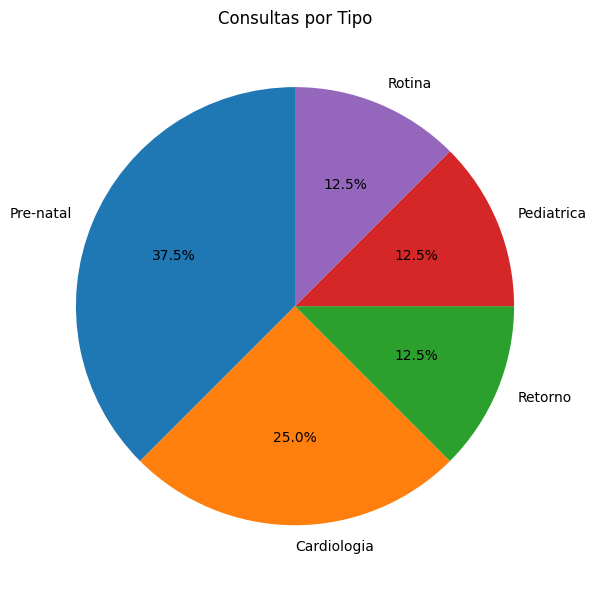

,tipo_consulta,total
0,Pre-natal,3
1,Cardiologia,2
2,Retorno,1
3,Pediatrica,1
4,Rotina,1


In [36]:
# Consultas por tipo (pizza)
grafico_consultas_por_tipo()

In [ ]:
# Consultas por mes (barras)
grafico_consultas_por_mes()

C:\Users\pc\AppData\Local\Temp\ipykernel_17484\3310307835.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


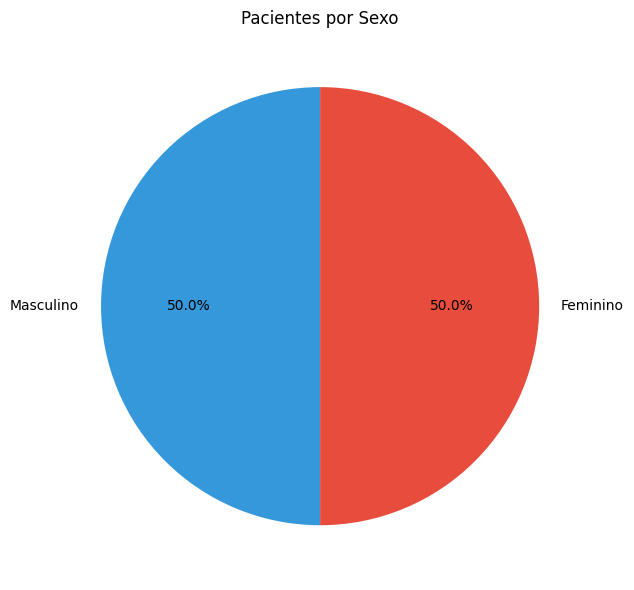

,sexo,total
0,Masculino,3
1,Feminino,3


In [37]:
# Pacientes por sexo (pizza)
grafico_pacientes_por_sexo()

In [ ]:
# Atendimentos por tipo (barras horizontais)
grafico_atendimentos_por_tipo()

In [ ]:
# Consultas por profissional
grafico_consultas_por_profissional()

In [ ]:
# Prescricoes por medicamento
grafico_prescricoes_por_medicamento()

In [ ]:
# Status de gestacao (mulheres)
grafico_gestantes()